# FIRIS/Firemap Data Assimilation



## Introduction

## Method

## Results

## Discussion

## Future Work

# Dependencies

In [1]:
# from kalmanutils import validate_geoms_matrix, interpolate_geometries
import farsiteutils_v2 as futils
import uuid
import datetime

import pandas as pd
import geopandas as gpd

from shapely.geometry import MultiPolygon, Polygon, Point, GeometryCollection
from shapely.validation import make_valid

from matplotlib import pyplot as plt
import numpy as np

import random 
import pickle

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.11/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


## Geometry handling - backend

In [2]:
def interpolate_perimeter(vertices, dnumber):
    # Changes the number of vertices of the given set of vertices
    if len(vertices) == dnumber:
        return vertices
    
    vertices = np.array(vertices)
    step_len = np.sqrt(np.sum(np.diff(vertices, 1, 0)**2, 1)) # length of each side
    step_len = np.append([0], step_len)
    cumulative_len = np.cumsum(step_len)
    interpolation_loc = np.linspace(0, cumulative_len[-1], dnumber)
    X = np.interp(interpolation_loc, cumulative_len, vertices[:,0])
    Y = np.interp(interpolation_loc, cumulative_len, vertices[:,1])

    return list(zip(X,Y))

def align_vertices(interpolated_vertices):
    minroll_lst = []
    
    aligned_vertices = [interpolated_vertices[0]]
    for i in range(len(interpolated_vertices)-1):
        right_vertices = interpolated_vertices[i+1]

        # Cycle right_vertices
        l2perroll = []
        for roll in range(len(interpolated_vertices[i])-1):
            diff = aligned_vertices[0] - right_vertices
            diff2sum = (diff[:,0]**2 + diff[:,1]**2).sum()

            # Calculate diff^2 in
            l2perroll.append(diff2sum)

            right_vertices = np.roll(right_vertices,1, axis=0)

        minroll_lst.append(np.argmin(l2perroll))

    for i in range(len(interpolated_vertices)-1):
        aligned_vertices.append(np.roll(interpolated_vertices[i+1], minroll_lst[i], axis=0))
    
    return aligned_vertices

def validate_geoms_matrix(X, aligned_vertices):
    Xnew = np.zeros((2*aligned_vertices.shape[0], X.shape[1]))

    for i in range(X.shape[1]):
        X_0 = X[:,i]
        x = X_0[::2]
        y = X_0[1::2]

        geom = Polygon(zip(x,y)).buffer(0)
        if isinstance(geom, MultiPolygon):
            geom = calculate_max_area_geom(geom)

        geom = np.array(interpolate_perimeter(geom.exterior.coords[:-1], aligned_vertices.shape[0]))
        geom = align_vertices([aligned_vertices, geom])[1]

        Xnew[:,i] = geom.flatten()

    # X = np.append(Xnew, X, axis=0)
    return Xnew

## Geometry handling - public

In [3]:
def make_ccw(geom):
    if not geom.exterior.is_ccw:
        return geom.reverse()
    
    return geom

def interpolate_geom(geom, vertex_count):
    return Polygon(interpolate_perimeter((geom.exterior.coords[:-1]), vertex_count))

def interpolate_geoms(geoms, vertex_count):
        
    interpolated_geoms = []
    for geom in geoms:
        interpolated_geoms.append(interpolate_geom(geom, vertex_count))
        
    return interpolated_geoms



def align_geoms(geoms, vertex_count): 
    '''
        Will align all the geometries based on geoms[0]
    '''
    
    # Calculate interpolated vertices first
    interpolated_geoms = interpolate_geoms(geoms, vertex_count)
    
    interpolated_vertices = [make_ccw(interpolated_geoms[0]).exterior.coords[:-1]]
    for geom in interpolated_geoms[1:]:
        interpolated_vertices.append(make_ccw(geom).exterior.coords[:-1])

    # for vertices in align_vertices(np.array(interpolated_vertices)):
    #     poly = Polygon(vertices)
    #     geom = interpolate_geom(validate_geom(poly), vertex_count)
            
    
    return [Polygon(vertices) for vertices in align_vertices(np.array(interpolated_vertices))]

def geom_to_vector(geom):
    return np.array(geom.exterior.coords[:-1]).reshape(1, 2*len(geom.exterior.coords[:-1]))

def geoms_to_matrix(geoms, vertex_count=None, aligned_geom=None, nsamples=None):
    if vertex_count == None:
        vertex_count = len(geoms[0].exterior.coords)-1
              
    assert (nsamples is not None), f'nsamples = {nsamples}, give a value!'
    X = np.zeros((2*vertex_count, nsamples))

    assert (nsamples == len(geoms)), f'Need to fill {nsamples-len(geoms)}/{nsamples}'
    
    if aligned_geom is not None:
        aligned_geoms = align_geoms([aligned_geom] + geoms, vertex_count)[1:]
    else:
        aligned_geoms = align_geoms(geoms, vertex_count)
        
    for i, geom in enumerate(aligned_geoms):
        X[:,i] = geom_to_vector(geom)
        
    return X

def matrix_to_geom(X):
    geoms = []
    
    for xix in range(X.shape[1]):
        geoms.append(Polygon(zip(X[::2,xix],X[1::2,xix])))
        
    return geoms

def sample_geometry(geom, rng, sigma=1):
    sampled_vertices = []
    
    # Choose a random direction
    theta = rng.uniform(0,2*np.pi)

    for (x,y) in geom.exterior.coords[:-1]:
        mu=0
        
        randx = rng.normal(mu, sigma)
        randy = rng.normal(mu, sigma)
        
#         # Choose a normal random radius based on the given sigma
#         radius = abs(random.gauss(mu, sigma))
        
#         # Calculate x and y distance for the random
#         randx = radius*np.cos(theta)
#         randy = radius*np.sin(theta)
        
        sampled_vertices.append((x+randx, y+randy))

    sampled_vertices = np.array(sampled_vertices)
    return Polygon(sampled_vertices)

def sample_windspeed(loc, sigma, rng):
    return rng.normal(loc, sigma)
def sample_winddirection(loc, sigma, rng):
    return np.fmod(rng.normal(loc, sigma)+360, 360)


def calculate_max_area_geom(multigeom):
    if isinstance(multigeom, GeometryCollection) | isinstance(multigeom, MultiPolygon):
        max_area = 0
        max_area_idx = 0
        for ix, g in enumerate(multigeom.geoms):
            if g.area > max_area:
                max_area = g.area
                max_area_idx = ix
        return calculate_max_area_geom(multigeom.geoms[max_area_idx])
    
    return multigeom

def validate_geom(poly):
    poly = make_valid(poly)
    if isinstance(poly, GeometryCollection) | isinstance(poly, MultiPolygon):
        poly = calculate_max_area_geom(poly)
    
    assert(isinstance(poly, Polygon)), 'buffered polygon is not a polygon'
    
    return poly

def fill_null_geoms(geoms, nsamples):
    X = geoms_to_matrix(geoms, nsamples=len(geoms))
    mu = X.mean(axis=1)
    stdev = X.std(axis=1)
    
    added_geoms = []
    for i in range(nsamples-len(geoms)):
        xy = np.random.normal(mu, stdev)
        geom = Polygon(zip(xy[::2], xy[1::2]))
        added_geoms.append(validate_geom(geom))
        
    return geoms + added_geoms

def fill_zeros(A, nonzerolen, nsamples):
    mu = A[:,:nonzerolen].mean(axis=1)
    stdev = A[:,:nonzerolen].std(axis=1)

    for i in range(nonzerolen, nsamples):
        # Calculate uncertainties for each point
        A[:,i] = np.random.normal(mu, stdev)
        
    return A

## Plotting

In [4]:
def plot_geometry(geom, ax = None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(4,4))
    
    if isinstance(geom, MultiPolygon):
        for g in geom.geoms:
            x,y = g.exterior.coords.xy
            ax.plot(x[:-1],y[:-1], **kwargs)
    else:
        x,y = geom.exterior.coords.xy
        ax.plot(x[:-1],y[:-1], **kwargs)
        
    ax.set_aspect('equal')
        
def plot_matrix(X, ax=None, show_stdev = False, **kwargs):
    vcounts = X.shape[0]//2
    
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(4,4))
    
    color = (1,0,0,0.9)
    if 'color' in kwargs:
        color = kwargs['color']
        
    X_std = np.std(X, axis=1)
    X_mean = np.mean(X, axis=1)
    ax.plot(X_mean[::2], X_mean[1::2], **kwargs)

    # Calculate standard deviation of the generated coordinates
    x0, y0 = X_mean[::2], X_mean[1::2]
    radstd = np.zeros_like(x0)
    
    for vix in range(vcounts):
        x,y = X[2*vix,:], X[2*vix+1,:]
        radius = np.sqrt((x-x0[vix])**2 +(y-y0[vix])**2)
        radstd[vix] = np.std(radius)
    
    if show_stdev:
        for vix in range(vcounts):
            circle = plt.Circle((x0[vix], y0[vix]), radius=radstd[vix], fill=False, edgecolor=(0,0,0,0.4), lw=0.3)
            ax.add_artist(circle)
            
    ax.set_aspect('equal')

def plot_matrix_ensemble(X, ax=None, plot_alix = None, alpha=0.1, **kwargs):
    
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(4,4))
        
    for vix in range(X.shape[1]):
        ax.plot(X[::2, vix], X[1::2, vix], **kwargs)
        
    if plot_alix is not None:
        ax.scatter(X[2*plot_alix,:], X[2*plot_alix+1, :], alpha = alpha, color=kwargs['color'], edgecolors=(0,0,0,0))
    ax.set_aspect('equal')

## Forward Pass

In [5]:
def calculate(initialidx, 
              observeidx,
              windspeed, winddirection, 
              usr: futils.User,
              lcpidx='43b7f5db36994599861eec4849cc68fd', 
              barrieridx='cb47616cd2dc4ccc8fd523bd3a5064bb'):

    
    # Setup the input data
    inputData = {'description': 'Maria_2019',
                 'igniteidx'  : initialidx,
                 'compareidx' : observeidx,
                 'lcpidx'     : lcpidx,
                 'barrieridx' : barrieridx,

                 'windspeed': windspeed, 'winddirection': winddirection,
                 'relhumid': 90, 'temperature': 20}

    mainapi = usr.calculatePerimeters(inputData)
    mainapi.run_farsite()

def forward_pass(poly, params):
    '''
        params: take values: 'windspeed', 'winddirection' ,'dt' (dt is a datetime.timedelta object)
    '''
    # Parameters to run the simulation
    windspeed = params['windspeed']
    winddirection = params['winddirection']
    dt = params['dt']
    
    # Create handles for simulation
    fp = futils.FilePaths(DATA_PATH)
    usr = futils.User(fp)

    initialidx = uuid.uuid4().hex
    fpath = f'/home/jovyan/farsite/inputs/maria_ignite/Reference/maria_{initialidx}.shp'
    # Creating the shp file for simulation
    gpd.GeoDataFrame({'FID': [0], 'geometry':poly}, crs='EPSG:5070').to_file(fpath)
    
    usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation', 
                                                                                               fpath, datetime.datetime.now(),
                                                                                               'Maria2019']
    
    observeidx = uuid.uuid4().hex
    # Add observationidx only to calculate the dt in the backend
    usr.db.dfObservation.loc[observeidx, 'datetime'] = usr.db.dfObservation.loc[initialidx, 'datetime'] + dt
    
    
    # Run simulation for dt from initialidx
    calculate(initialidx, observeidx, windspeed, winddirection, usr)
    
    # add simulation as the next initial point
    dfsim = usr.db.dfsimulation[(usr.db.dfsimulation['igniteidx'] == initialidx) & 
                            (usr.db.dfsimulation['compareidx'] == observeidx)]
    
    if len(dfsim) < 1:
        return None
    
    # assert(len(dfsim) == 1) , f'Length of dfsim = {len(dfsim)}'
    if len(dfsim) != 1:
        raise ValueError(f'Length of dfsim = {len(dfsim)}')

    usr.db.dfObservation.loc[dfsim.index[0], ['filetype', 'description']] = ['Observation', 'Maria2019']
    

    simpath = f'/home/jovyan/farsite/inputs/maria_ignite/Reference/maria_{observeidx}.shp'
    dfgeom = gpd.read_file(dfsim['filepath'].iloc[0])['geometry']
    assert(len(dfgeom) == 1), f'dfgeom has size = {len(dfgeom)}'
    dfgeom = dfgeom[0]
    return Polygon(dfgeom.coords)

## EnKF Update

In [6]:
def update_EnKF(Xt, Y):
    nsamples = Y.shape[1]

    xt = Xt.mean(axis=1, keepdims=True)
    y = Y.mean(axis=1, keepdims=True)

    Ex = Xt - xt.repeat(nsamples, axis=1)
    Ey = Y - y.repeat(nsamples, axis=1)

    Py = 1/(nsamples)*np.matmul(Ey, Ey.T)
    Px = 1/(nsamples)*np.matmul(Ex, Ex.T)

    Pxy_inv = np.linalg.pinv(Px + Py, hermitian=True)

    assert(np.allclose(np.matmul(Pxy_inv, (Px+Py)), np.eye(Y.shape[0]))), 'Inverse calculation is incorrect'

    K = np.matmul(Px, Pxy_inv)

    # Note that Xt has additional +2 in it
    # Remove that with the matrix C
    C = np.eye(Y.shape[0], Xt.shape[0])
    #### Update the state ensemble
    # X = Xt + np.matmul(K, (Y - np.matmul(C, Xt)))
    X = Xt + np.matmul(K, (Y - Xt))

    ### TODO ####
    # Fix invalid geometries

    # X = validate_geoms_matrix(X, aligned_geom)

    return X, K

## Error Calculation

In [7]:
def calculate_rms(geom1, geom2, vertex_count=100):
    g1, g2 = align_geoms([geom1, geom2], vertex_count=vertex_count)
    xy1 = np.array(g1.exterior.coords[:-1])
    xy2 = np.array(g2.exterior.coords[:-1])
    return np.sqrt(np.sum((xy1[:,0] - xy2[:,0])**2 + (xy1[:,1] - xy2[:,1])**2)/xy1.shape[0])
    

def calculate_area_diff(geom1, geom2):
    return (geom1.union(geom2) - geom1.intersection(geom2)).area

# Reference Example

In [8]:
# Default values
SELECTED_FIRE_DEFAULT = 'Maria2019'
DATA_PATH = '/home/jovyan/data/'    # Folder to keep all the data while running the simulations

# Create handles for simulation
fp = futils.FilePaths(DATA_PATH)
usr = futils.User(fp)

## Generate ground truth

In [9]:
# ignition is a 100x100 square from the centroid, centered at (cx, cy)
cx, cy = gpd.read_file(usr.db.dfObservation.iloc[0]['filepath'])['geometry'][0].centroid.xy
cx = cx[0]
cy = cy[0]
size = 100
ignition = Polygon(((cx-size/2,cy-size/2), (cx-size/2,cy+size/2), (cx+size/2,cy+size/2), (cx+size/2, cy-size/2)))

# wind speed and wind direction for ground truth are set for each simulation, every 30 minutes
wslst = [11, 18, 18, 25, 17, 22, 15, 12, 14, 14, 14]
wdlst = [37, 48, 48, 44, 16, 29, 19, 24, 22, 21, 20]
tlst = np.arange(0,0.5*len(wslst), 0.5)

In [10]:
ground_truth_geoms = [ignition]

poly=ignition
for ws, wd in zip(wslst, wdlst):
    params = {'windspeed': ws, 'winddirection': wd, 'dt': datetime.timedelta(minutes=30)}
    simpoly = forward_pass(poly, params)
    ground_truth_geoms.append(validate_geom(simpoly))
    poly = simpoly

### Plot Ground truth polygons

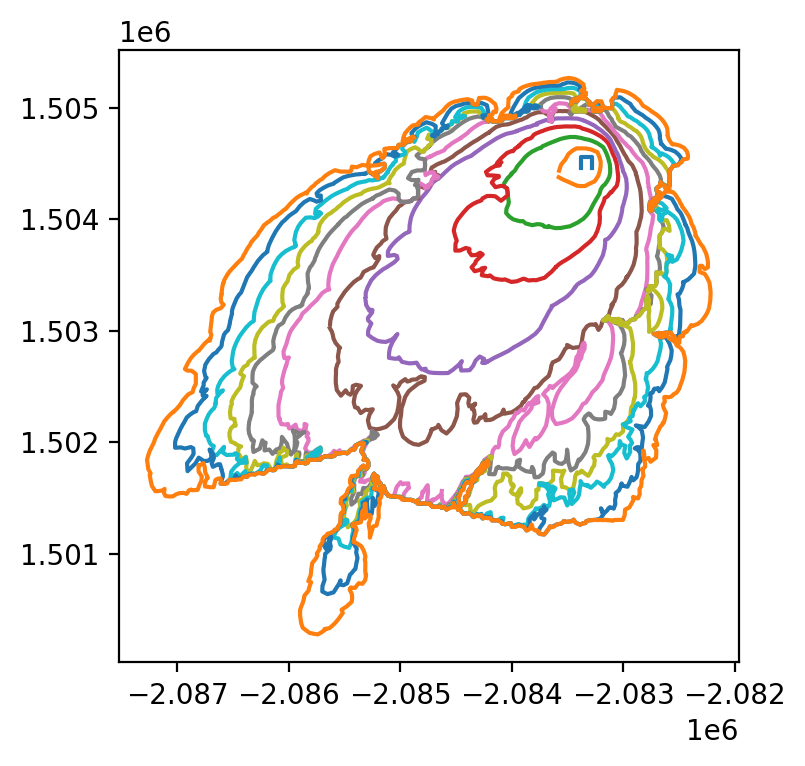

In [11]:
# Ground Truth polygons
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

for geom in ground_truth_geoms:
    plot_geometry(geom=geom, ax=ax)

## Generate observation

In [12]:
geom_tolerance = 100
geom_sigma = 250
ws_sigma = 3
wd_sigma = 50

observation_geoms = []
observation_ws = []
observation_wd = []

rng = np.random.Generator(np.random.PCG64(1234))
for geom, ws, wd in zip(ground_truth_geoms, wslst, wdlst):
    observation_geoms.append(validate_geom(sample_geometry(validate_geom(geom.simplify(geom_tolerance)), rng, sigma=geom_sigma)))
    observation_ws.append(sample_windspeed(ws, ws_sigma, rng))
    observation_wd.append(sample_winddirection(wd, wd_sigma, rng))

### Plot Ground Truth and Observations

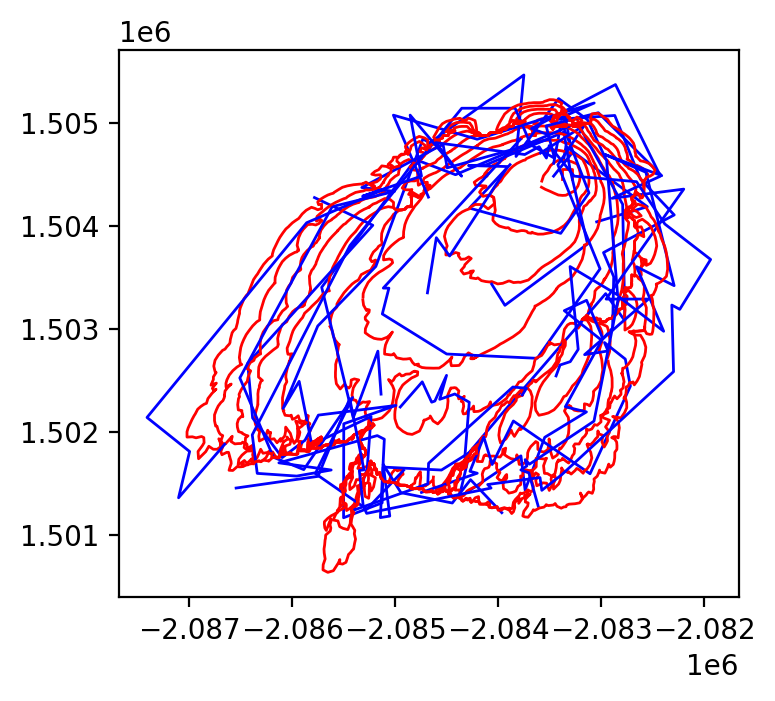

In [13]:
# Ground Truth polygons
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

rms_error = []
area_error = []
for geom_tru, geom_obs in zip(ground_truth_geoms, observation_geoms):
    plot_geometry(geom=geom_tru, ax=ax, color=(1,0,0), lw=1)
    plot_geometry(geom=geom_obs, ax=ax, color=(0,0,1), lw=1)

    rms_error.append(calculate_rms(geom_tru, geom_obs, vertex_count=1000))
    area_error.append(calculate_area_diff(geom_tru, geom_obs))

### RMS Error of observation

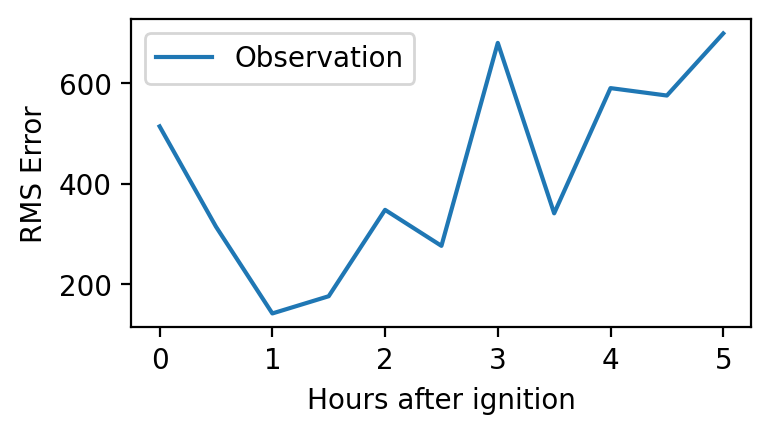

In [14]:
fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=200)

ax.plot(tlst, rms_error, label='Observation')
ax.set_xlabel('Hours after ignition')
ax.set_ylabel('RMS Error')

ax.legend()

## Run forward simulations from ignition

In [15]:
forward_from_ignition = [observation_geoms[0]]

poly=forward_from_ignition[0]
for i in range(len(ground_truth_geoms[1:])):
    print(f'Calculationg {i}/{len(ground_truth_geoms)-1}')
    params = {'windspeed': observation_ws[0], 'winddirection': observation_wd[0], 'dt': datetime.timedelta(minutes=30)}
    simpoly = forward_pass(poly, params)
    forward_from_ignition.append(validate_geom(simpoly))
    poly = simpoly

Calculationg 0/11
Calculationg 1/11
Calculationg 2/11
Calculationg 3/11
Calculationg 4/11
Calculationg 5/11
Calculationg 6/11
Calculationg 7/11
Calculationg 8/11
Calculationg 9/11
Calculationg 10/11


### Plot forward simulations

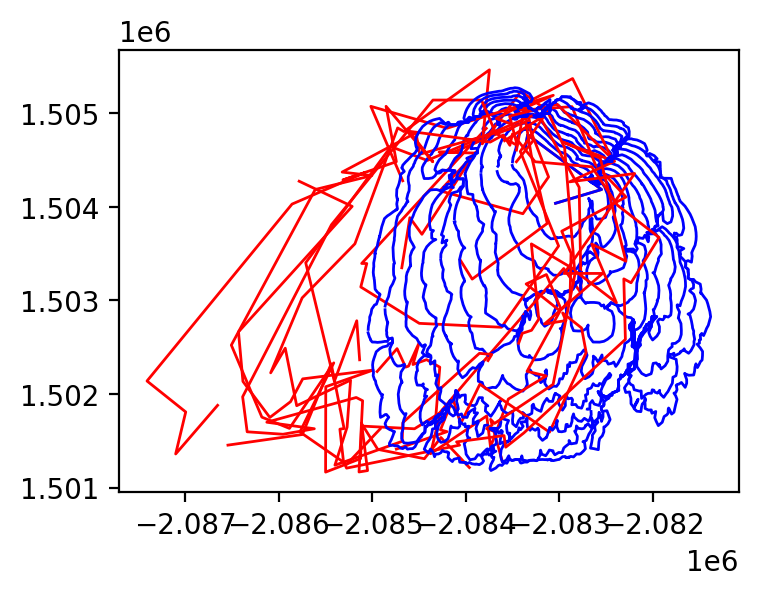

In [16]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

rms_error_obs = []
rms_error_frw = []
for geom_obs, geom_frw, geom_truth in zip(observation_geoms, forward_from_ignition, ground_truth_geoms):
    plot_geometry(geom_obs, ax=ax, color=(1,0,0), lw=1)
    plot_geometry(geom_frw, ax=ax, color=(0,0,1),lw=1)

    rms_error_obs.append(calculate_rms(geom_obs, geom_truth, vertex_count=1000))
    rms_error_frw.append(calculate_rms(geom_frw, geom_truth, vertex_count=1000))

### RMS Error comparision observation and forward sim

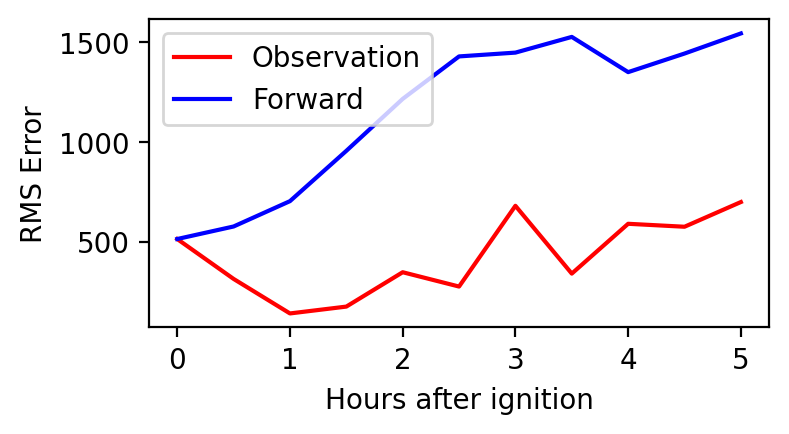

In [17]:
fig ,ax = plt.subplots(1,1, figsize=(4,2), dpi=200)

ax.plot(tlst, rms_error_obs, 'r-', label='Observation')
ax.plot(tlst, rms_error_frw, 'b-', label='Forward')

ax.set_xlabel('Hours after ignition')
ax.set_ylabel('RMS Error')

ax.legend()

## Continuous adjustment to the observation and simulation through EnKF

In [18]:
nsamples = 250
nvertex = 100

observation_geom_sigma = 250
observation_wd_sigma = wd_sigma
observation_ws_sigma = ws_sigma

data = {'calculations': [],
        'parameters': {'nsamples': nsamples,
                       'nvertex': nvertex,
                       'observation_geom_sigma': observation_geom_sigma,
                       'observation_wd_sigma': observation_wd_sigma,
                       'observation_ws_sigma': observation_ws_sigma
                       },
       }


adjusted_geoms = [observation_geoms[0]]
for upix in range(1, len(observation_geoms)):
    print(f'Calculating {upix-1}-->{upix}')
    
    observed_geom = observation_geoms[upix]
    observed_wd = observation_wd[upix]
    observed_ws = observation_ws[upix]

    initial_poly = adjusted_geoms[upix-1]

    Xt_geoms = []
    Y_geoms = []
    sampled_wdlst = []
    sampled_wslst = []
    for s in range(nsamples):
        # Farsite Parameters for forward simulation
        ws = sample_windspeed(observed_ws, observation_ws_sigma, rng)
        sampled_wslst.append(ws)
        wd = sample_winddirection(observed_wd, observation_wd_sigma, rng)
        sampled_wdlst.append(wd)
        forward_geom = forward_pass(initial_poly, params = {'windspeed': ws,
                                                            'winddirection': wd,
                                                            'dt': datetime.timedelta(minutes=30)})
        if forward_geom is not None:
            Xt_geoms.append(forward_geom)

        # Sample observation
        Y_geoms.append(sample_geometry(observed_geom, rng, observation_geom_sigma))

    filled_count = nsamples-len(Xt_geoms)
    if filled_count > 0:
        Xt_geoms = fill_null_geoms(Xt_geoms, nsamples)

    Y = geoms_to_matrix(Y_geoms, vertex_count=nvertex, nsamples=nsamples, aligned_geom=observation_geoms[0])
    Xt = geoms_to_matrix(Xt_geoms, vertex_count=nvertex, nsamples=nsamples, aligned_geom=observation_geoms[0])
    X, K = update_EnKF(Xt, Y)

    Xmean = X.mean(axis=1)
    x,y = Xmean[::2], Xmean[1::2]
    adjusted_geoms.append(validate_geom(Polygon(zip(x,y))))
    
    data['calculations'].append({'initial_poly': initial_poly,
                             'aligned_geom': observation_geoms[0],
                             'filled_geoms': filled_count,
                              'Xt': Xt, 'X': X, 'Y': Y,
                              'wdar': sampled_wdlst, 'wsar': sampled_wslst})
    
    with open('/home/jovyan/data/output_reftest_09142023.pkl', 'wb') as f:
        pickle.dump(data, f)


Calculating 0-->1
Calculating 1-->2
Calculating 2-->3
Calculating 3-->4
Calculating 4-->5
Calculating 5-->6
Calculating 6-->7
Calculating 7-->8
Calculating 8-->9
Calculating 9-->10


### RMS Error comparison

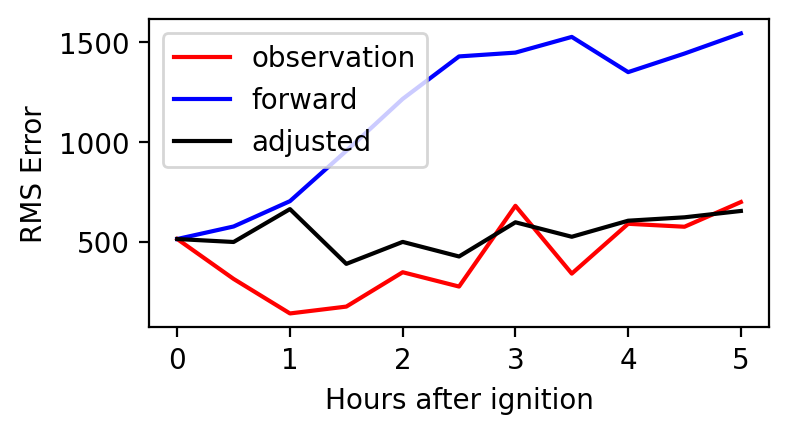

In [22]:
rms_error_obs = []
rms_error_fwd = []
rms_error_adj = []

area_error_obs = []
area_error_fwd = []
area_error_adj = []
for gix in range(len(adjusted_geoms)):
    geom_obs = observation_geoms[gix]
    geom_fwd = forward_from_ignition[gix]
    geom_adj = adjusted_geoms[gix]
    geom_tru = ground_truth_geoms[gix]

    rms_error_obs.append(calculate_rms(geom_obs, geom_tru, vertex_count=1000))
    rms_error_fwd.append(calculate_rms(geom_fwd, geom_tru, vertex_count=1000))
    rms_error_adj.append(calculate_rms(geom_adj, geom_tru, vertex_count=1000))

    area_error_obs.append(calculate_area_diff(geom_obs, geom_tru))
    area_error_fwd.append(calculate_area_diff(geom_fwd, geom_tru))
    area_error_adj.append(calculate_area_diff(geom_adj, geom_tru))


# Plot comparison
fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=200)

ax.plot(tlst[:len(adjusted_geoms)], rms_error_obs, label='observation', color='r')
ax.plot(tlst[:len(adjusted_geoms)], rms_error_fwd, label='forward', color='b')
ax.plot(tlst[:len(adjusted_geoms)], rms_error_adj, label='adjusted', color='k')

ax.set_xlabel('Hours after ignition')
ax.set_ylabel('RMS Error')

# ax2 = ax.twinx()
# ax2.plot(tlst[:len(adjusted_geoms)], area_error_obs, color='r', ls='--')
# ax2.plot(tlst[:len(adjusted_geoms)], area_error_fwd, color='b', ls='--')
# ax2.plot(tlst[:len(adjusted_geoms)], area_error_adj, color='k', ls='--')
# ax2.set_ylabel('Area diff error')

ax.legend()
